DAG Graph

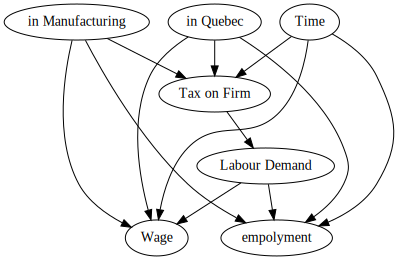

In [22]:
from graphviz import Digraph
g = Digraph()

g.edge("Tax on Firm","Labour Demand")
g.edge("Labour Demand","Wage")
g.edge("Labour Demand","empolyment")
g.edge("Time","Tax on Firm")
g.edge("Time","Wage")
g.edge("Time","empolyment")
g.edge("in Quebec","Tax on Firm")
g.edge("in Quebec","Wage")
g.edge("in Quebec","empolyment")
g.edge("in Manufacturing","Tax on Firm")
g.edge("in Manufacturing","Wage")
g.edge("in Manufacturing","empolyment")

g

Import libararies

In [23]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import math

Wage

Clean Data

In [24]:
all_wages_url = 'https://raw.githubusercontent.com/Foxluna9/ECON-526-Final-project/main/all_wages.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_all_wages = pd.read_csv(all_wages_url, skiprows=14, skipfooter=15, header=None, engine='python')

# name the headers
df_all_wages = df_all_wages.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'all_wages'})

# fill all missing values based on the most previously available value of the column
df_all_wages = df_all_wages.fillna(method='ffill')
 # change the data type of the column year to int
df_all_wages['year'] = df_all_wages['year'].astype(np.float32).astype(int)
  
# change the data type of the input column col to int or float based on num_decimals
df_all_wages['all_wages'] = df_all_wages['all_wages'].replace({',': ''}, regex=True)
df_all_wages['all_wages'] = df_all_wages['all_wages'].astype(np.float32)
if 1 == 0:
   df_all_wages['all_wages'] = df_all_wages['all_wages'].astype(int)
else:
   df_all_wages['all_wages'] = df_all_wages['all_wages'].round(1)

# get the log value of column 'all_wages'
log_var = 'log_' + 'all_wages'
df_all_wages[log_var] = np.log(df_all_wages['all_wages'])
  
# generate dummy variables for province, sector and year variables
df_all_wages['is_quebec'] = (df_all_wages['province'] == 'Quebec')
df_all_wages['is_manu'] = (df_all_wages['sector'] == 'Manufacturing')
df_all_wages['is_after_reform'] = (df_all_wages['year'] >= 2014)
df_all_wages = df_all_wages.astype({'is_quebec': int, 'is_manu': int, 'is_after_reform': int})

# generate province-and-sector dummy variable is_manu_quebec, 
df_all_wages['is_manu_quebec'] = df_all_wages['is_manu'] * df_all_wages['is_quebec']

# compute Log(all_wages)
df_all_wages['all_wages'] = np.log(df_all_wages['all_wages'])
df_all_wages.head()


,province,sector,year,all_wages,log_all_wages,is_quebec,is_manu,is_after_reform,is_manu_quebec
0,Quebec,Construction,2011,5.195177,5.195177,1,0,0,0
1,Quebec,Construction,2012,5.218191,5.218191,1,0,0,0
2,Quebec,Construction,2013,5.260615,5.260615,1,0,0,0
3,Quebec,Construction,2014,5.165928,5.165928,1,0,1,0
4,Quebec,Construction,2015,5.088213,5.088213,1,0,1,0


Plot wage data

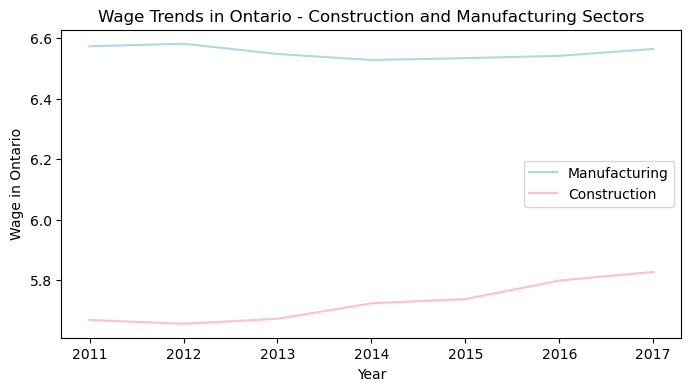

In [25]:
plt.figure(figsize=(8, 4))

year = df_all_wages.query("province == 'Ontario' & sector == 'Construction'")['year']
onstruct = df_all_wages.query("province == 'Ontario' & sector == 'Construction'")['all_wages']
manuf = df_all_wages.query("province == 'Ontario' & sector == 'Manufacturing'")['all_wages']

plt.errorbar(x=year, y=onstruct, color='pink', label='Construction')
plt.plot(year, manuf, color='lightblue', label='Manufacturing')

plt.xlabel('Year')
plt.ylabel('Wage in Ontario')
plt.title('Wage Trends in Ontario - Construction and Manufacturing Sectors')
plt.legend()
plt.show()

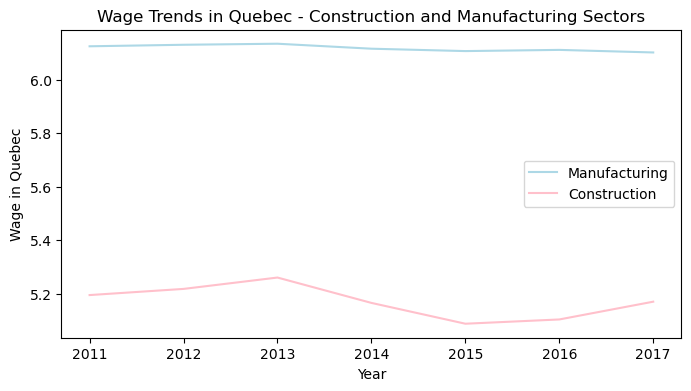

In [26]:
plt.figure(figsize=(8, 4))

year = df_all_wages.query("province == 'Quebec' & sector == 'Construction'")['year']
onstruct = df_all_wages.query("province == 'Quebec' & sector == 'Construction'")['all_wages']
manuf = df_all_wages.query("province == 'Quebec' & sector == 'Manufacturing'")['all_wages']

plt.errorbar(x=year, y=onstruct, color='pink', label='Construction')
plt.plot(year, manuf, color='lightblue', label='Manufacturing')

plt.xlabel('Year')
plt.ylabel('Wage in Quebec')
plt.title('Wage Trends in Quebec - Construction and Manufacturing Sectors')
plt.legend()
plt.show()

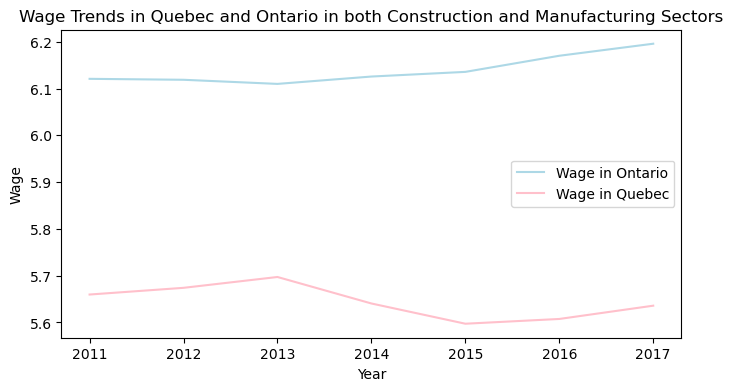

In [27]:
plt.figure(figsize=(8, 4))

result = df_all_wages.groupby(['province','year'])['all_wages'].sum().reset_index()

year = result.query("province == 'Quebec'")['year']

Ave_wage_Quebec = result.query("province == 'Quebec'")['all_wages']/2
Ave_wage_Ontario = result.query("province == 'Ontario'")['all_wages']/2
plt.errorbar(x=year, y=Ave_wage_Quebec, color='pink', label='Wage in Quebec')
plt.plot(year, Ave_wage_Ontario, color='lightblue', label='Wage in Ontario')

plt.xlabel('Year')
plt.ylabel('Wage')
plt.title('Wage Trends in Quebec and Ontario in both Construction and Manufacturing Sectors')
plt.legend()
plt.show()

Diff-in-Diff ols model

In [28]:
# Sellect only Quebec Data
Quebec_wage= df_all_wages[df_all_wages['province'] == "Quebec"]
Quebec_wage.head()

,province,sector,year,all_wages,log_all_wages,is_quebec,is_manu,is_after_reform,is_manu_quebec
0,Quebec,Construction,2011,5.195177,5.195177,1,0,0,0
1,Quebec,Construction,2012,5.218191,5.218191,1,0,0,0
2,Quebec,Construction,2013,5.260615,5.260615,1,0,0,0
3,Quebec,Construction,2014,5.165928,5.165928,1,0,1,0
4,Quebec,Construction,2015,5.088213,5.088213,1,0,1,0


In [29]:
dif_in_dif_log_wage = smf.ols(formula='log_all_wages ~ is_after_reform*is_manu + is_after_reform + is_manu',
                 data=Quebec_wage).fit()
dif_in_dif_log_wage.summary().tables[1]

/Users/foxluna/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.2247,0.016,326.437,0.000,5.189,5.260
is_after_reform,-0.0925,0.021,-4.368,0.001,-0.140,-0.045
is_manu,0.9045,0.023,39.959,0.000,0.854,0.955
is_after_reform:is_manu,0.0715,0.030,2.389,0.038,0.005,0.138


Tripe in Diff for wage

-OLS model

In [30]:

# perform triple difference by ols regression
ols_wage = smf.ols(formula='log_all_wages ~ is_after_reform * is_manu + is_after_reform * is_quebec \
                           + is_after_reform * is_manu * is_quebec',
                 data=df_all_wages).fit()
ols_wage.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.6652,0.017,341.110,0.000,5.631,5.700
is_after_reform,0.1063,0.022,4.838,0.000,0.060,0.152
is_manu,0.9028,0.023,38.436,0.000,0.854,0.952
is_after_reform:is_manu,-0.1319,0.031,-4.245,0.000,-0.197,-0.067
is_quebec,-0.4406,0.023,-18.758,0.000,-0.490,-0.392
is_after_reform:is_quebec,-0.1988,0.031,-6.397,0.000,-0.264,-0.134
is_manu:is_quebec,0.0017,0.033,0.051,0.960,-0.068,0.071
is_after_reform:is_manu:is_quebec,0.2034,0.044,4.630,0.000,0.112,0.295


In [31]:

# perform ols by years
validation_all_wages = smf.ols(formula='log_all_wages ~ C(year):is_manu:is_quebec + C(year):is_manu \
                                  + C(year):is_quebec + is_manu + is_quebec + is_manu_quebec',
                 data=df_all_wages).fit()
validation_all_wages.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.7260,0.025,226.496,0.000,5.664,5.788
C(year)[2011]:is_manu:is_quebec,-0.0220,0.107,-0.205,0.844,-0.285,0.241
C(year)[2012]:is_manu:is_quebec,-0.0479,0.107,-0.445,0.672,-0.311,0.215
C(year)[2013]:is_manu:is_quebec,-0.0524,0.107,-0.488,0.643,-0.315,0.210
C(year)[2014]:is_manu:is_quebec,0.0435,0.107,0.405,0.700,-0.219,0.306
C(year)[2015]:is_manu:is_quebec,0.1063,0.107,0.990,0.361,-0.157,0.369
C(year)[2016]:is_manu:is_quebec,0.0872,0.107,0.812,0.448,-0.176,0.350
C(year)[2017]:is_manu:is_quebec,-0.0115,0.107,-0.107,0.918,-0.274,0.251
is_manu,0.8477,0.072,11.855,0.000,0.673,1.023
C(year)[T.2012]:is_manu,0.0085,0.095,0.090,0.931,-0.223,0.240


/var/folders/ck/ghtf5y557r570cwm02yp6fv00000gn/T/ipykernel_17050/343344723.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Tripe_in_dif['coef_norm'] = Tripe_in_dif['coef'] - float(Tripe_in_dif['coef'].loc[Tripe_in_dif['year'] == 2013])


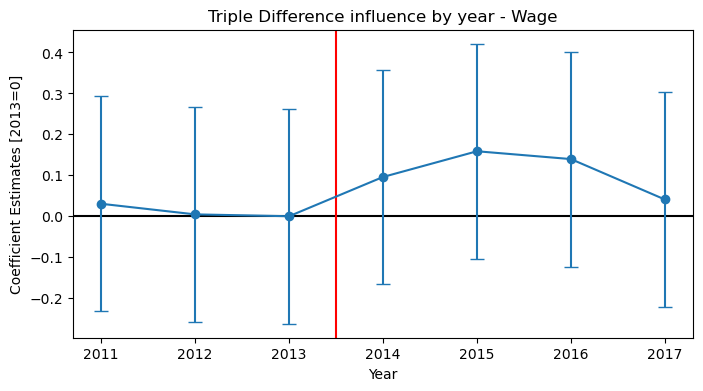

In [32]:
summary = validation_all_wages.summary()

df_coef = pd.read_html(summary.tables[1].as_html(), header=0)[0]
Tripe_in_dif = df_coef.iloc[1:8]
Tripe_in_dif = Tripe_in_dif.rename(columns={'Unnamed: 0': 'year'})
Tripe_in_dif
Tripe_in_dif['year'] = range(2011, 2018)
Tripe_in_dif['coef_norm'] = Tripe_in_dif['coef'] - float(Tripe_in_dif['coef'].loc[Tripe_in_dif['year'] == 2013])
Tripe_in_dif['loerr'] = Tripe_in_dif['coef'] - Tripe_in_dif['[0.025']
Tripe_in_dif['uperr'] = Tripe_in_dif['0.975]'] - Tripe_in_dif['coef']


plt.figure(figsize=(8,4))

# plot horizontal reference line y = 0 and time-series reference line x = 2013.5
plt.axhline(0, color='black')
plt.axvline(2013.5, color='red')
# plot line graph of coefficients for each year and error bars,
# where error bars represent the 2.5% confidence interval to 97.5% confidence interval range
plt.errorbar(x=Tripe_in_dif['year'], y=Tripe_in_dif['coef_norm'], 
            yerr=np.array(Tripe_in_dif[['loerr','uperr']].T), 
            fmt='-o', capsize=5)
plt.xlabel('Year')
plt.ylabel('Coefficient Estimates [2013=0]')
plt.title('Triple Difference influence by year - Wage')
plt.show()

Empolyment

Clean Data

In [33]:

emp_url = 'https://raw.githubusercontent.com/Foxluna9/ECON-526-Final-project/main/employment.csv'

df_emp_monthly = pd.read_csv(emp_url, skiprows=11, skipfooter=18, header=None, engine='python')
df_emp_monthly = df_emp_monthly.rename(columns={0: 'province', 1: 'sector', 2: 'monthyear', 3: 'employment'})
df_emp_monthly
df_emp_monthly['year'] = df_emp_monthly['monthyear'].str[-4:]
# fill all missing values based on the most previously available value of the column
df_emp_monthly = df_emp_monthly.fillna(method='ffill')
 # change the data type of the column year to int
df_emp_monthly['year'] = df_emp_monthly['year'].astype(np.float32).astype(int)
  
# change the data type of the input column col to int or float based on num_decimals
df_emp_monthly['employment'] = df_emp_monthly['employment'].replace({',': ''}, regex=True)
df_emp_monthly['employment'] = df_emp_monthly['employment'].astype(np.float32)
if 0 == 0:
   df_emp_monthly['employment'] = df_emp_monthly['employment'].astype(int)
else:
   df_emp_monthly['employment'] = df_emp_monthly['employment'].round(0)

# get the log value of column 'employment'
log_var = 'log_' + 'employment'
df_emp_monthly[log_var] = np.log(df_emp_monthly['employment'])
  
# generate dummy variables for province, sector and year variables
df_emp_monthly['is_quebec'] = (df_emp_monthly['province'] == 'Quebec')
df_emp_monthly['is_manu'] = (df_emp_monthly['sector'] == 'Manufacturing')
df_emp_monthly['is_after_reform'] = (df_emp_monthly['year'] >= 2014)
df_emp_monthly = df_emp_monthly.astype({'is_quebec': int, 'is_manu': int, 'is_after_reform': int})

# generate province-and-sector dummy variable is_manu_quebec, 
df_emp_monthly['is_manu_quebec'] = df_emp_monthly['is_manu'] * df_emp_monthly['is_quebec']

# Since the employment is monthly data, for each sector and province combination, calculate its mean employment over each year
# to get an estimate of the acutal annual employment per sector-province combination
df_emp = df_emp_monthly.groupby(['year', 'province', 'sector', 'is_quebec', 'is_manu', 
                                 'is_manu_quebec', 'is_after_reform']).mean('employment').reset_index()
df_emp['employment'] = df_emp['employment'].astype(int)

# compute Log(employment)
df_emp['log_employment'] = np.log(df_emp['employment'])

df_emp.head()


,year,province,sector,is_quebec,is_manu,is_manu_quebec,is_after_reform,employment,log_employment
0,2011,Ontario,Construction,0,0,0,0,281774,12.548861
1,2011,Ontario,Manufacturing,0,1,0,0,654746,13.392003
2,2011,Quebec,Construction,1,0,0,0,178295,12.091195
3,2011,Quebec,Manufacturing,1,1,1,0,419194,12.946089
4,2012,Ontario,Construction,0,0,0,0,291414,12.582500


Plot Data

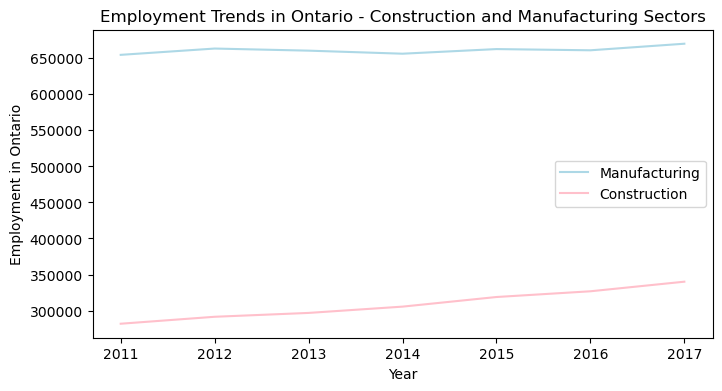

In [34]:
plt.figure(figsize=(8, 4))

year = df_emp.query("province == 'Ontario' & sector == 'Construction'")['year']
employment_construct = df_emp.query("province == 'Ontario' & sector == 'Construction'")['employment']
employment_manuf = df_emp.query("province == 'Ontario' & sector == 'Manufacturing'")['employment']

plt.errorbar(x=year, y=employment_construct, color='pink', label='Construction')
plt.plot(year, employment_manuf, color='lightblue', label='Manufacturing')

plt.xlabel('Year')
plt.ylabel('Employment in Ontario')
plt.title('Employment Trends in Ontario - Construction and Manufacturing Sectors')
plt.legend()
plt.show()



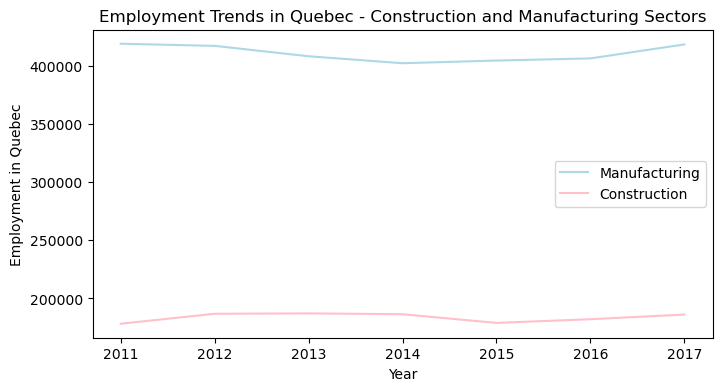

In [35]:
plt.figure(figsize=(8, 4))

year = df_emp.query("province == 'Quebec' & sector == 'Construction'")['year']
employment_construct = df_emp.query("province == 'Quebec' & sector == 'Construction'")['employment']
employment_manuf = df_emp.query("province == 'Quebec' & sector == 'Manufacturing'")['employment']

plt.errorbar(x=year, y=employment_construct, color='pink', label='Construction')
plt.plot(year, employment_manuf, color='lightblue', label='Manufacturing')

plt.xlabel('Year')
plt.ylabel('Employment in Quebec')
plt.title('Employment Trends in Quebec - Construction and Manufacturing Sectors')
plt.legend()
plt.show()

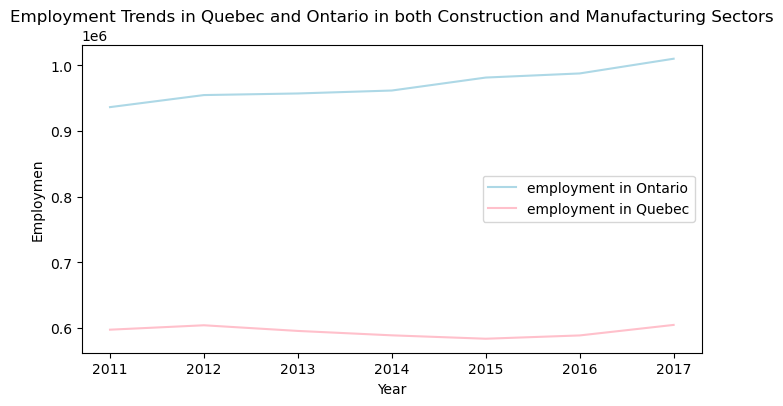

In [36]:
plt.figure(figsize=(8, 4))

result = df_emp.groupby(['province','year'])['employment'].sum().reset_index()

year = result.query("province == 'Quebec'")['year']

T_employ_Quebec = result.query("province == 'Quebec'")['employment']
T_employ_Ontario = result.query("province == 'Ontario'")['employment']
plt.errorbar(x=year, y=T_employ_Quebec, color='pink', label='employment in Quebec')
plt.plot(year, T_employ_Ontario, color='lightblue', label='employment in Ontario')

plt.xlabel('Year')
plt.ylabel('Employmen')
plt.title('Employment Trends in Quebec and Ontario in both Construction and Manufacturing Sectors')
plt.legend()
plt.show()

Dif-in-Dif

In [37]:
# Sellect only Quebec Data
Quebec_emp= df_emp[df_emp['province'] == "Quebec"]
Quebec_emp.head()

,year,province,sector,is_quebec,is_manu,is_manu_quebec,is_after_reform,employment,log_employment
2,2011,Quebec,Construction,1,0,0,0,178295,12.091195
3,2011,Quebec,Manufacturing,1,1,1,0,419194,12.946089
6,2012,Quebec,Construction,1,0,0,0,186857,12.138099
7,2012,Quebec,Manufacturing,1,1,1,0,417350,12.941680
10,2013,Quebec,Construction,1,0,0,0,187187,12.139863


In [38]:
# perform difference in difference by ols regression
dif_in_dif_log_employment = smf.ols(formula='log_employment ~ is_after_reform*is_manu + is_after_reform + is_manu',
                 data=Quebec_emp).fit()
dif_in_dif_log_employment.summary().tables[1]

/Users/foxluna/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.1231,0.012,1053.802,0.000,12.097,12.149
is_after_reform,-0.0035,0.015,-0.227,0.825,-0.037,0.030
is_manu,0.8129,0.016,49.964,0.000,0.777,0.849
is_after_reform:is_manu,-0.0134,0.022,-0.623,0.548,-0.061,0.035


Tripe in Diff for Emoplyment

OLS model

In [39]:
# perform triple difference by ols regression
ols_emp = smf.ols(formula='log_employment ~ is_after_reform * is_manu + is_after_reform * is_quebec \
                           + is_after_reform * is_manu * is_quebec',
                 data=df_emp).fit()
ols_emp.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.5773,0.014,899.603,0.000,12.548,12.607
is_after_reform,0.1067,0.018,5.767,0.000,0.068,0.145
is_manu,0.8220,0.020,41.575,0.000,0.781,0.863
is_after_reform:is_manu,-0.1022,0.026,-3.906,0.001,-0.157,-0.048
is_quebec,-0.4543,0.020,-22.977,0.000,-0.496,-0.413
is_after_reform:is_quebec,-0.1101,0.026,-4.210,0.000,-0.165,-0.056
is_manu:is_quebec,-0.0092,0.028,-0.327,0.747,-0.067,0.049
is_after_reform:is_manu:is_quebec,0.0888,0.037,2.400,0.026,0.012,0.166


In [40]:
validation_emp = smf.ols(formula='log_employment ~ C(year):is_manu:is_quebec + C(year):is_manu \
                                  + C(year):is_quebec + is_manu + is_quebec + is_manu_quebec',
                 data=df_emp).fit()
validation_emp.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.6383,0.025,498.985,0.000,12.576,12.700
C(year)[2011]:is_manu:is_quebec,0.0648,0.108,0.602,0.569,-0.199,0.328
C(year)[2012]:is_manu:is_quebec,0.0002,0.108,0.002,0.998,-0.263,0.264
C(year)[2013]:is_manu:is_quebec,-0.0188,0.108,-0.175,0.867,-0.282,0.245
C(year)[2014]:is_manu:is_quebec,-0.0233,0.108,-0.217,0.836,-0.287,0.240
C(year)[2015]:is_manu:is_quebec,0.0135,0.108,0.125,0.904,-0.250,0.277
C(year)[2016]:is_manu:is_quebec,0.0031,0.108,0.029,0.978,-0.260,0.266
C(year)[2017]:is_manu:is_quebec,-0.0032,0.108,-0.030,0.977,-0.267,0.260
is_manu,0.7537,0.072,10.521,0.000,0.578,0.929
C(year)[T.2012]:is_manu,0.0133,0.095,0.140,0.893,-0.219,0.245


/var/folders/ck/ghtf5y557r570cwm02yp6fv00000gn/T/ipykernel_17050/1370258606.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Tripe_in_dif['coef_norm'] = Tripe_in_dif['coef'] - float(Tripe_in_dif['coef'].loc[Tripe_in_dif['year'] == 2013])


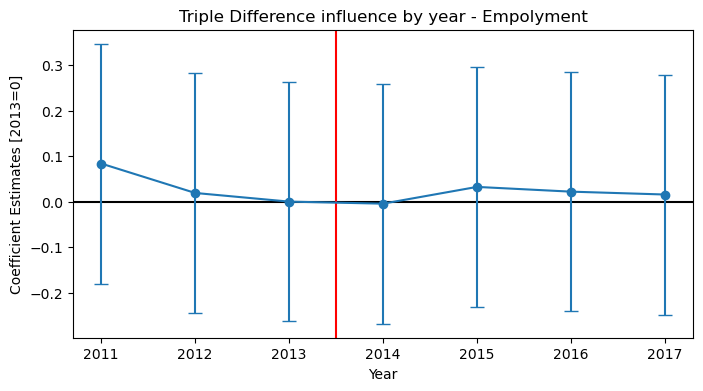

In [41]:
summary = validation_emp.summary()

df_coef = pd.read_html(summary.tables[1].as_html(), header=0)[0]
Tripe_in_dif = df_coef.iloc[1:8]
Tripe_in_dif = Tripe_in_dif.rename(columns={'Unnamed: 0': 'year'})
Tripe_in_dif
Tripe_in_dif['year'] = range(2011, 2018)
Tripe_in_dif['coef_norm'] = Tripe_in_dif['coef'] - float(Tripe_in_dif['coef'].loc[Tripe_in_dif['year'] == 2013])
Tripe_in_dif['loerr'] = Tripe_in_dif['coef'] - Tripe_in_dif['[0.025']
Tripe_in_dif['uperr'] = Tripe_in_dif['0.975]'] - Tripe_in_dif['coef']


plt.figure(figsize=(8,4))

# plot horizontal reference line y = 0 and time-series reference line x = 2013.5
plt.axhline(0, color='black')
plt.axvline(2013.5, color='red')
# plot line graph of coefficients for each year and error bars,
# where error bars represent the 2.5% confidence interval to 97.5% confidence interval range
plt.errorbar(x=Tripe_in_dif['year'], y=Tripe_in_dif['coef_norm'], 
            yerr=np.array(Tripe_in_dif[['loerr','uperr']].T), 
            fmt='-o', capsize=5)
plt.xlabel('Year')
plt.ylabel('Coefficient Estimates [2013=0]')
plt.title('Triple Difference influence by year - Empolyment')
plt.show()